This notebook is my first attempt at figuring out how to code up the "concordance" analysis (i.e. are effect directions more often in the same direction than would be expected by chance?)

In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

In [65]:
fqvals = '../../data/analysis_results/qvalues.mean.kruskal-wallis.case-control.txt'

df = pd.read_csv(fqvals, sep='\t', index_col=0)
df.columns

Index([u'cdi_youngster', u'hiv_noguerajulian', u'hiv_lozupone',
       u't1d_alkanani', u'edd_singh', u'asd_son', u'crc_zeller', u'liv_zhang',
       u'ibd_papa', u'ob_zhu', u'crc_baxter', u'cdi_schubert',
       u'par_scheperjans', u'crc_wang', u'ibd_gevers', u'nash_zhu',
       u'cdi_vincent', u'ob_ross', u'asd_kang', u'art_scher', u'crc_chen',
       u'ob_goodrich', u'hiv_dinh', u'noncdi_schubert', u'ibd_morgan',
       u'ob_zupancic', u'ob_turnbaugh', u't1d_mejialeon', u'ibd_willing',
       u'nash_wong'],
      dtype='object')

In [66]:
# If something is not significant, make it zero (not nan)
sigmap = lambda x: np.sign(x) if abs(x) < qthresh else 0

In [67]:
# Pick one representative study per disease. If multiple studies have significant genera, 
# pick the study with the largest sample size. If only one study has significant
# genera, pick that one. If no studies have significant genera, don't include that
# disease in this analysis
dis2study = {'cdi': 'cdi_schubert', 'ob': 'ob_goodrich', 
             'crc': 'crc_baxter', 'ibd': 'ibd_gevers', 
             'hiv': 'hiv_noguerajulian', 'nash': 'nash_zhu', 
             'liv': 'liv_zhang', 'par': 'par_scheperjans'}
alldiseases = dis2study.keys()


In [113]:
def get_n_concord(df, col1, col2):
    """
    Get the number of concordant values in col1 and col2 of df.
    
    Values that are nan in one column and not nan in the other are
    considered discordant. Values that are nan in both columns are
    dropped.
    
    Note: if you've converted your dataframe of qvalues to +/- 1
    values, this code converts zeros to NaN's so that they are
    not considered concordant (np.nan == np.nan is False, 
    but 0 == 0 is True).
    """
    tmp = df[[col1, col2]].dropna(how='all')
    tmp = tmp.replace(0, np.nan)

    return sum(tmp[col1] == tmp[col2])

def shuffle_col(col):
    """
    Shuffles the index labels of one column after dropping NaN's.

    Calling df.apply(shuffle_col) shuffles each column values but preserves
    the location of NaN's.

    (Why does this work? Because this function returns a Series with only
    the non-NaN indices. When you call shuffle_col on an entire dataframe,
    I think pandas just fills in the missing indices with NaN's...)
    """
    newcol = pd.Series(
        data=col.dropna().values,
        index=np.random.permutation(col.dropna().index))
    return newcol

In [123]:
n_reps = 100

# Use qthresh = 1 to consider the effect direction regardless of significance
qthresh = 0.05
effdir = df.applymap(sigmap)

dist = []

# Actual values
for dis1 in alldiseases:
    for dis2 in alldiseases[alldiseases.index(dis1)+1:]:
        study1 = dis2study[dis1]
        study2 = dis2study[dis2]
        
        n_concord = get_n_concord(effdir, study1, study2)
        dist.append([dis1, dis2, study1, study2, 'observed', n_concord])

# Shuffled values
for n in range(n_reps):
    # Shuffled entire dataframe once
    shuffledeffdir = effdir.copy().apply(shuffle_col)
    
    # Then recount the number of concordant directions
    for dis1 in alldiseases:
        for dis2 in alldiseases[alldiseases.index(dis1)+1:]:
            study1 = dis2study[dis1]
            study2 = dis2study[dis2]

            n_concord = get_n_concord(shuffledeffdir, study1, study2)
            dist.append([dis1, dis2, study1, study2, 'expected', n_concord])

In [124]:
distdf = pd.DataFrame(data=dist, columns=['dis1', 'dis2', 'study1', 'study2', 'metric', 'n_concord'])

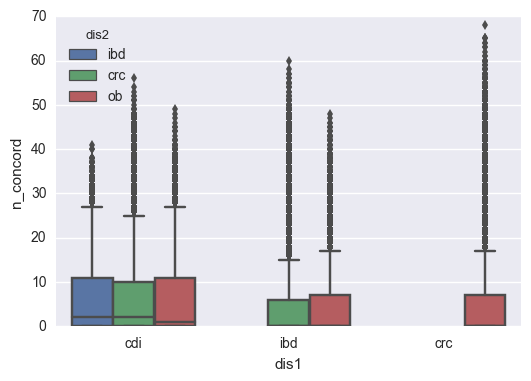

In [63]:
sns.boxplot(data=distdf.query('metric == "expected"'), x='dis1', hue='dis2', y='n_concord')

In [69]:
#for g, subdf in distdf.groupby(['study1','study2']):
#    print(g)
#    n_obs = subdf.query('metric == "observed"')['n_concord'].values
#    n_exp = subdf.query('metric == "expected"')['n_concord'].values
#    print(sum(n_exp >= n_obs)/float(len(n_exp)))


In [128]:
distdf.query('study1 == "cdi_schubert"').query('study2 == "ob_goodrich"').head()


,dis1,dis2,study1,study2,metric,n_concord
27,cdi,ob,cdi_schubert,ob_goodrich,observed,7
55,cdi,ob,cdi_schubert,ob_goodrich,expected,1
83,cdi,ob,cdi_schubert,ob_goodrich,expected,2
111,cdi,ob,cdi_schubert,ob_goodrich,expected,0
139,cdi,ob,cdi_schubert,ob_goodrich,expected,2


# Concordance analysis

- Calculate the p-values for each disease pair
- Average those p-values (or plot the distribution of them, for now?)
- Re-calculate these p-values for different q-value thresholds (i.e. are we just looking at direction of any effect, or are we looking at direction of significant effects...)
    - Rationale: I think concordance gets more significant if you're looking at the effect direction of significant or marginally significant things, rather than just any old effect direction...
    
Facet plot: rows and columns are [cdi, ob, crc, ibd].

Plots have x-axis = q-value threshold, y-axis = distribution of p-values for each sutdy-combo at that q-value

In [114]:
sigmap = lambda x: np.sign(x) if abs(x) < qthresh else 0

n_reps = 250

#qthreshs = [0.01, 0.05, 0.1, 0.5, 0.85, 1]
#alldiseases = ['cdi', 'ibd', 'crc', 'ob']
qthreshs = [0.01, 0.1, 1]
alldiseases = dis2study.keys()

# Rename edd_singh to cdi_singh
df = df.rename(columns={'edd_singh': 'cdi_singh'})

dist = []

for qthresh in qthreshs:
    print(qthresh)
    effdir = df.applymap(sigmap)
    
    # Actual values
    for dis1 in alldiseases:
        dis1_studies = [i for i in df.columns if i.startswith(dis1)]
        for dis2 in alldiseases[alldiseases.index(dis1)+1:]:
            dis2_studies = [i for i in df.columns if i.startswith(dis2)]

            for study1 in dis1_studies:
                for study2 in dis2_studies:

                    n_concord = get_n_concord(effdir, study1, study2)
                    dist.append([dis1, dis2, study1, study2, 'observed', n_concord, qthresh])

    # Shuffled values
    for n in range(n_reps):
        # Shuffled entire dataframe once
        shuffledeffdir = effdir.copy().apply(shuffle_col)

        # Then recount the number of concordant directions
        for dis1 in alldiseases:
            dis1_studies = [i for i in df.columns if i.startswith(dis1)]
            for dis2 in alldiseases[alldiseases.index(dis1)+1:]:
                dis2_studies = [i for i in df.columns if i.startswith(dis2)]

                for study1 in dis1_studies:
                    for study2 in dis2_studies:

                        n_concord = get_n_concord(shuffledeffdir, study1, study2)
                        dist.append([dis1, dis2, study1, study2, 'expected', n_concord, qthresh])

0.01
0.1
1


In [115]:
distdf = pd.DataFrame(data=dist, columns=['dis1', 'dis2', 'study1', 'study2', 'metric', 'n_concord', 'qthresh'])

In [116]:
#g = sns.FacetGrid(data=distdf.query('metric == "expected"'), row='dis1', col='dis2')
#g.map(sns.boxplot, 'qthresh', 'n_concord')

In [117]:
#g = sns.FacetGrid(data=distdf.query('metric == "observed"'), row='dis1', col='dis2')
#g.map(sns.stripplot, 'qthresh', 'n_concord')

In [118]:
# Calculate p-values from the empirical distributions
pvals = []

for g, subdf in distdf.groupby(['study1','study2', 'qthresh']):
    n_obs = subdf.query('metric == "observed"')['n_concord'].values
    n_exp = subdf.query('metric == "expected"')['n_concord'].values
    p = sum(n_exp >= n_obs)/float(len(n_exp))
    
    pvals.append(list(g) + [p, subdf['dis1'].iloc[0], subdf['dis2'].iloc[0]])

In [119]:
pdf = pd.DataFrame(data=pvals, columns=['study1', 'study2', 'qthresh', 'p', 'dis1', 'dis2'])
pdf['logp'] = np.log10(pdf['p'])

/Users/claire/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


In [120]:
pdf.query('qthresh == 1').groupby(['dis1', 'dis2']).mean()

qthresh         p  logp
dis1 dis2                         
cdi  ob        1.0  0.024800  -inf
crc  cdi       1.0  0.057500  -inf
     hiv       1.0  0.021667  -inf
     ibd       1.0  0.028750  -inf
     liv       1.0  0.002000  -inf
     nash      1.0  0.002000  -inf
     ob        1.0  0.034000  -inf
     par       1.0  0.001000  -inf
hiv  cdi       1.0  0.013667  -inf
     ibd       1.0  0.007667  -inf
     nash      1.0  0.001333  -inf
     ob        1.0  0.001333  -inf
ibd  cdi       1.0  0.000000  -inf
     ob        1.0  0.003200  -inf
liv  cdi       1.0  0.057000  -inf
     hiv       1.0  0.014667  -inf
     ibd       1.0  0.000000  -inf
     nash      1.0  0.000000  -inf
     ob        1.0  0.000800  -inf
     par       1.0  0.000000  -inf
nash cdi       1.0  0.001500  -inf
     ibd       1.0  0.000000  -inf
     ob        1.0  0.000000  -inf
par  cdi       1.0  0.024000  -inf
     hiv       1.0  0.000000  -inf
     ibd       1.0  0.017000  -inf
     nash      1.0  0.000000  -inf
     ob        1.0  0.006400  -inf

In [123]:
pdf.head()

,study1,study2,qthresh,p,dis1,dis2,logp
0,cdi_schubert,ob_goodrich,0.01,1.0,cdi,ob,0.000000
1,cdi_schubert,ob_goodrich,0.10,0.0,cdi,ob,-inf
2,cdi_schubert,ob_goodrich,1.00,0.0,cdi,ob,-inf
3,cdi_schubert,ob_ross,0.01,1.0,cdi,ob,0.000000
4,cdi_schubert,ob_ross,0.10,1.0,cdi,ob,0.000000


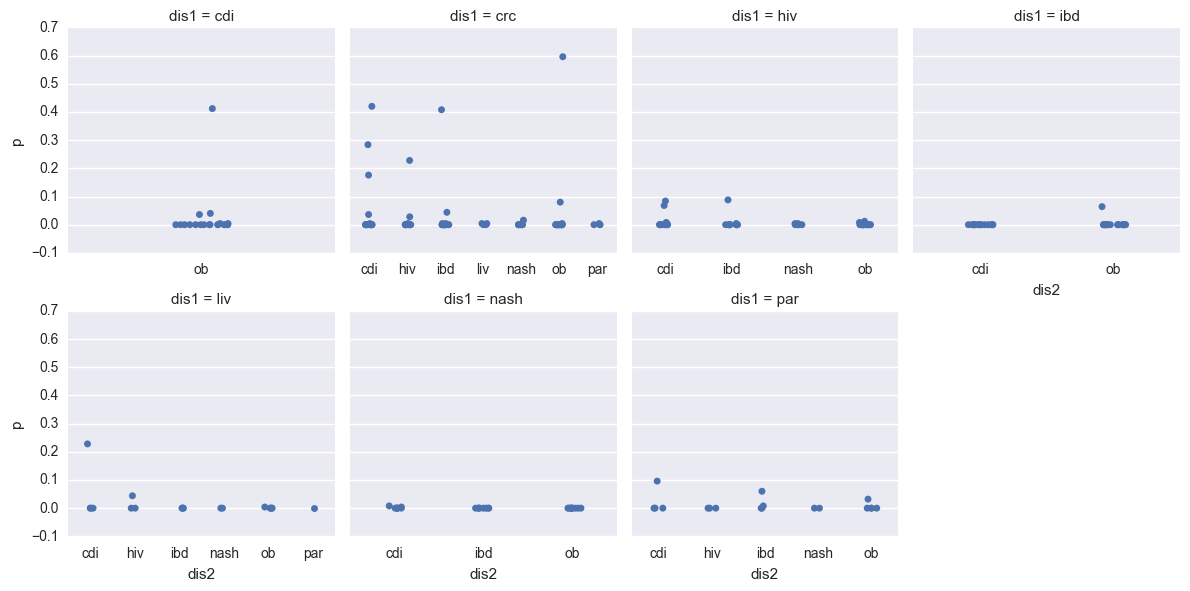

In [124]:
g = sns.FacetGrid(data=pdf.query('qthresh == 1'), col='dis1', sharex=False, col_wrap=4)
g.map(sns.stripplot, 'dis2', 'p', jitter=True)

In [126]:
pdf.query('qthresh == 1')['p'].mean()

0.015065573770491808

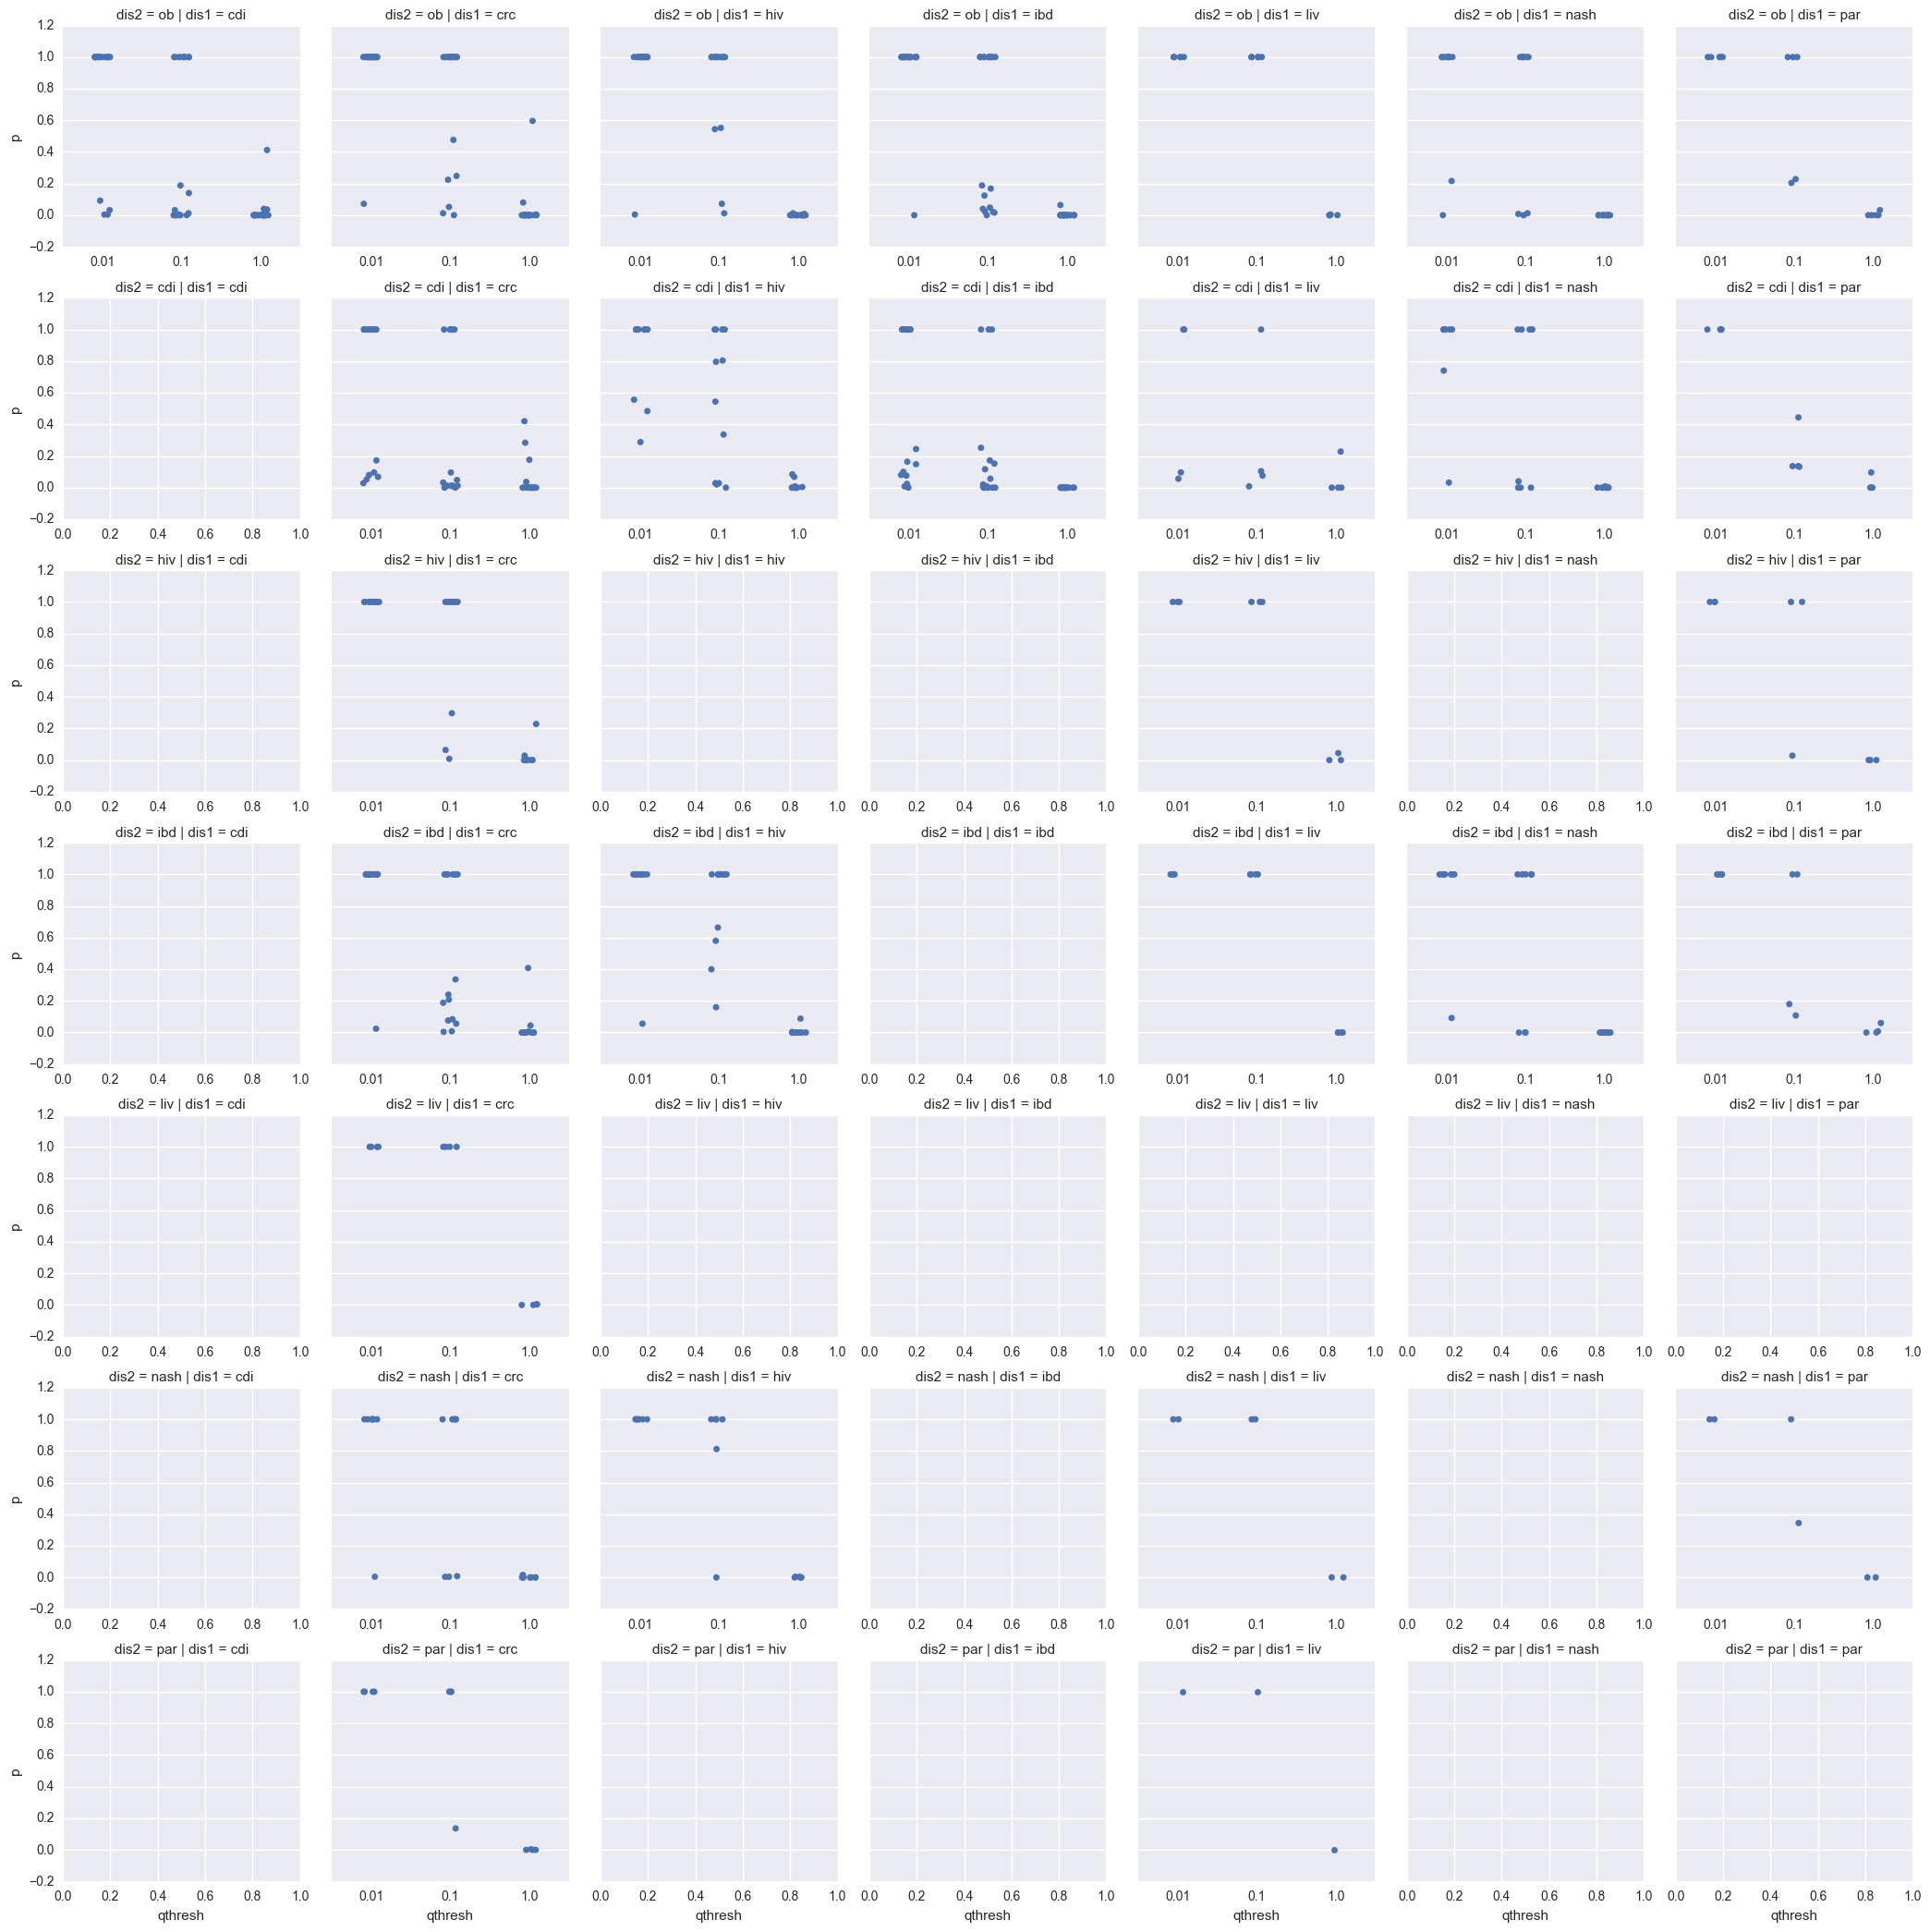

In [129]:
g = sns.FacetGrid(data=pdf, col='dis1', row='dis2', sharex=False)
g.map(sns.stripplot, 'qthresh', 'p', jitter=True)

# Calculate exact pvalues

Do some sort of Fisher's exact test to calculate the exact pvalues.

In [27]:
import pandas as pd
import numpy as np

from scipy.stats import fisher_exact, chi2_contingency

from IPython.display import display

In [2]:
fqvals = '../../data/analysis_results/qvalues.mean.kruskal-wallis.case-control.txt'

df = pd.read_csv(fqvals, sep='\t', index_col=0)
df.columns

Index([u'cdi_youngster', u'hiv_noguerajulian', u'hiv_lozupone',
       u't1d_alkanani', u'edd_singh', u'asd_son', u'crc_zeller', u'liv_zhang',
       u'ibd_papa', u'ob_zhu', u'crc_baxter', u'cdi_schubert',
       u'par_scheperjans', u'crc_wang', u'ibd_gevers', u'nash_zhu',
       u'cdi_vincent', u'ob_ross', u'asd_kang', u'art_scher', u'crc_chen',
       u'ob_goodrich', u'hiv_dinh', u'noncdi_schubert', u'ibd_morgan',
       u'ob_zupancic', u'ob_turnbaugh', u't1d_mejialeon', u'ibd_willing',
       u'nash_wong'],
      dtype='object')

In [4]:
# Pick one representative study per disease. If multiple studies have significant genera, 
# pick the study with the largest sample size. If only one study has significant
# genera, pick that one. If no studies have significant genera, don't include that
# disease in this analysis
dis2study = {'cdi': 'cdi_schubert', 'ob': 'ob_goodrich', 
             'crc': 'crc_baxter', 'ibd': 'ibd_gevers', 
             'hiv': 'hiv_noguerajulian', 'nash': 'nash_zhu', 
             'liv': 'liv_zhang', 'par': 'par_scheperjans'}
alldiseases = dis2study.keys()


In [11]:
qthresh = 1
effdir = np.sign(df)
effdir.head()

,cdi_youngster,hiv_noguerajulian,hiv_lozupone,t1d_alkanani,edd_singh,asd_son,crc_zeller,liv_zhang,ibd_papa,ob_zhu,...,crc_chen,ob_goodrich,hiv_dinh,noncdi_schubert,ibd_morgan,ob_zupancic,ob_turnbaugh,t1d_mejialeon,ibd_willing,nash_wong
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter,NaN,-1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,-1.0,NaN,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera,NaN,1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,...,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomassiliicoccaceae;g__Methanomassiliicoccus,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
s1 = 'ibd_papa'
s2 = 'nash_wong'

display(pd.crosstab(effdir[s1], effdir[s2]))
print(fisher_exact(pd.crosstab(effdir[s1], effdir[s2])))
print(chi2_contingency(pd.crosstab(effdir[s1], effdir[s2])))

display(pd.crosstab(effdir.fillna('nan')[s1], effdir.fillna('nan')[s2]))
print(chi2_contingency(pd.crosstab(effdir.fillna('nan')[s1], effdir.fillna(0)[s2])))

tmp = pd.crosstab(effdir[[s1,s2]].dropna(how='all').fillna('nan')[s1], effdir[[s1,s2]].dropna(how='all').fillna('nan')[s2])
display(tmp)
print(chi2_contingency(tmp))

nash_wong,-1.0,1.0
ibd_papa,,
-1.0,12,7
1.0,7,4


(0.97959183673469385, 1.0)
(0.13461230283189493, 0.71369697339503013, 1, array([[ 12.03333333,   6.96666667],
       [  6.96666667,   4.03333333]]))


nash_wong,-1.0,1.0,nan
ibd_papa,,,
-1.0,12,7,18
1.0,7,4,28
nan,1,4,217


(87.70942994764286, 4.0359649199699565e-18, 4, array([[   2.48322148,   32.65436242,    1.86241611],
       [   2.61744966,   34.41946309,    1.96308725],
       [  14.89932886,  195.9261745 ,   11.17449664]]))


nash_wong,-1.0,1.0,nan
ibd_papa,,,
-1.0,12,7,18
1.0,7,4,28
nan,1,4,0


(18.124859441381183, 0.0011666474598810491, 4, array([[  9.13580247,   6.85185185,  21.01234568],
       [  9.62962963,   7.22222222,  22.14814815],
       [  1.2345679 ,   0.92592593,   2.83950617]]))


## How to deal with NaN's?

- Ignore them and only look at bugs which are present in both studies. This is way too conservative, probs.
- Consider them their own category, and do a 3x3 chi2
    - But I don't really care about bugs which are NaN in both studies. Is removing them legit?
- Re-think of contingency table as:

[up in s1 AND up in s2]     [up in s1 AND (down in s2 OR not present in s2)]     
[(down in s1 OR not present in s1) AND up in s2]     [down in s1 AND down in s2]


```
s1    s2

up    up   
up    down   
up    NaN (down)   
down  down   
down  up   
down  NaN (up)
NaN (down)   up   
NaN (up)  down
NaN   NaN  
```

Oh wait, another option is just to fill any NaN's with the opposite thing, so it becomes...

[up in s1 AND up in s2]     [(up in s1 or nan in s1) AND (down in s2 OR nan in s2)]     
[(down in s1 or nan in s1) AND (up in s2 or nan in s2)]     [down in s1 AND down in s2]

Let's try calculating p-values from looking only at bugs that are in both studies. And the one with 3x3, dropping cells where both are NaN. And then this last one.

## Let's calculate!

